
# Parameters → Image (baseline)
Baseline conditional image predictor using a fast, non-deep-learning model:
- Loads the foam NSID files
- Picks a subset of tabular features (time, heights/volumes, lamella thickness) as inputs
- Downsamples frames to 64×64
- Uses a kNN regressor to predict images from parameters


In [14]:

from pathlib import Path

# Locate data/foam irrespective of where the kernel is started
candidates = []
nb_dir = Path.cwd()
candidates.append(nb_dir)
candidates.append(nb_dir.parent)
candidates.append(nb_dir.parent.parent)
candidates.append(nb_dir / '..')
candidates.append(Path(r'C:\Users\aisci\OneDrive\Desktop\Foam bubble data\DTMicroscope-main'))

DATA_DIR = None
for base in candidates:
    candidate = (Path(base).resolve() / 'data' / 'foam')
    if candidate.exists():
        DATA_DIR = candidate
        break

if DATA_DIR is None:
    raise FileNotFoundError('Could not find data/foam. Set DATA_DIR manually below.')

h5_files = sorted(DATA_DIR.glob('*.h5'))
if not h5_files:
    raise FileNotFoundError(f'No .h5 files in {DATA_DIR}. Run scripts/convert_foam_to_h5.py first.')

H5_PATH = h5_files[0]
print('Using', H5_PATH)


Using C:\Users\aisci\OneDrive\Desktop\Foam bubble data\DTMicroscope-main\data\foam\0_5_wt_coco_betain_0_5wt_capryl_glucoside.h5


In [15]:

import numpy as np
import pandas as pd
from PIL import Image
from SciFiReaders import NSIDReader
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

reader = NSIDReader(str(H5_PATH))
datasets = reader.read()
im_ds = datasets["Channel_000"]
feat_ds = datasets["Channel_001"]

feature_names = [
    f.decode() if isinstance(f, (bytes, bytearray)) else f
    for f in feat_ds.metadata.get("feature_names", [])
]
feat_df = pd.DataFrame(feat_ds.compute(), columns=feature_names)
feat_df.columns = [
    (c.decode() if isinstance(c, (bytes, bytearray)) else c) for c in feat_df.columns
]

# Candidate input features (drop missing ones gracefully)
preferred_cols = [
    "t [s]",
    "hfoam [mm]",
    "hliquid [mm]",
    "Vfoam [mL]",
    "Vliquid [mL]",
    "BC [mm^-2]",
    "lamella_thickness_mm",
]
input_cols = [c for c in preferred_cols if c in feat_df.columns]
if not input_cols:
    raise ValueError(f"No matching input features found. Got columns: {feat_df.columns}")
X = feat_df[input_cols].copy()

frames = im_ds.compute().astype(np.float32)
target_size = 64

def downsample_frame(frame: np.ndarray) -> np.ndarray:
    img = Image.fromarray(frame.astype(np.uint8))
    img = img.resize((target_size, target_size))
    return np.array(img, dtype=np.float32) / 255.0

frames_to_use = min(len(frames), 300)  # keep it light
small_frames = np.stack([downsample_frame(frames[i]) for i in range(frames_to_use)])
X = X.iloc[:frames_to_use]

y = small_frames.reshape(frames_to_use, -1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=5, weights="distance")),
    ]
)
model.fit(X_train, y_train)
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"MSE on held-out frames: {mse:.6f}")


MSE on held-out frames: 0.004404


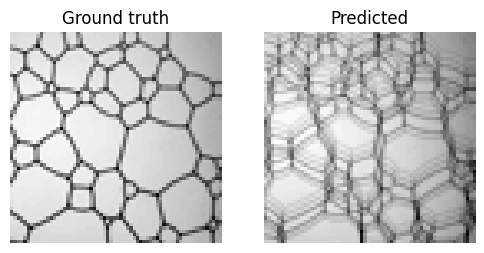

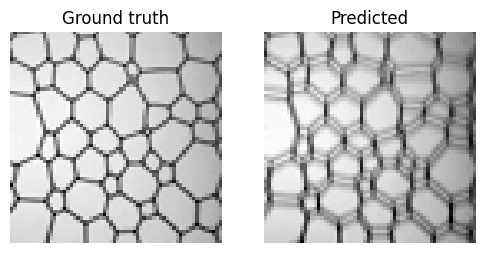

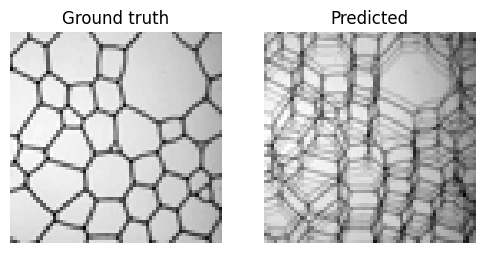

In [16]:

import matplotlib.pyplot as plt

# Visualize a few predictions
n_show = 3
for i in range(n_show):
    gt = y_test[i].reshape(target_size, target_size)
    pred = preds[i].reshape(target_size, target_size)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(gt, cmap="gray")
    axes[0].set_title("Ground truth")
    axes[0].axis("off")
    axes[1].imshow(pred, cmap="gray")
    axes[1].set_title("Predicted")
    axes[1].axis("off")
    plt.show()


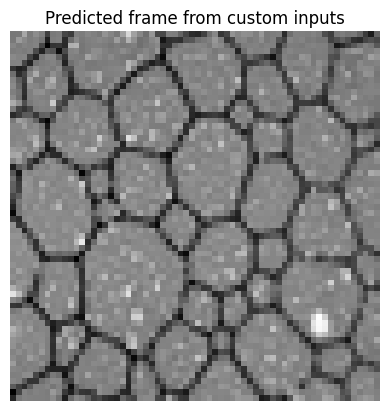

In [18]:

# Predict a new frame from custom parameters
# Fill in values for the features used in training (others optional)
input_example = {
    "t [s]": 53,
    "hfoam [mm]": 5,
    "hliquid [mm]": 10,
    "Vfoam [mL]": 4,
    "Vliquid [mL]": 20,
    "BC [mm^-2]": 120,
    "lamella_thickness_mm": 10,
}

# Keep only keys that exist in X
filtered = {k: v for k, v in input_example.items() if k in X.columns}
custom_df = pd.DataFrame([filtered])
# Align column order
custom_df = custom_df.reindex(columns=X.columns)

pred_vec = model.predict(custom_df)[0]
pred_img = pred_vec.reshape(target_size, target_size)

import matplotlib.pyplot as plt
plt.imshow(pred_img, cmap='gray')
plt.title('Predicted frame from custom inputs')
plt.axis('off')
plt.show()
